In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.optimize as spo
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Search EPS of the past 5 years + growth rate
from urllib import urlopen
from bs4 import BeautifulSoup

def eps_finder(symbol):
    # para escolher a ação, substituir 'goog' pela cia desejada (símbolo, e.g. 'aapl' = Apple)
    url = 'http://www.marketwatch.com/investing/stock/'+ symbol +'/financials'
    text_soup = BeautifulSoup(urlopen(url).read(), "lxml") #read in

    titles = text_soup.findAll('td', {'class': 'rowTitle'})
    for title in titles:
        if 'EPS (Basic)' in title.text:
            return [td.text for td in title.findNextSiblings(attrs={'class': 'valueCell'}) if td.text]

# Extract and preprocess data from CSV files of the 3 stocks

In [3]:
def prepare_data(symbol):
    df = pd.read_csv("data/" +symbol.upper() + ".csv", index_col="Date",usecols=["Date","Open","High", "Low","Close", "Volume", "Adj Close"], parse_dates=True, na_values=['nan'])
    feats = df.drop('Adj Close', 1)
    target = df['Adj Close']
    feats.loc[:,'Daily_var'] = feats.loc[:,'High'] - feats.loc[:,'Low']
    feats.loc[:,'Pct_var'] = feats.loc[:,'Daily_var'] / feats.loc[:,'Open'] * 100
    # compute Daily Returns
    daily_returns = (target / target.shift(1)) - 1
    daily_returns.iloc[0] = 0
    #print daily_returns
    feats.loc[:,'Daily_rets'] = daily_returns
    # Compute Cumulative Returns
    cum_ret = (target / target.iloc[0]) - 1
    cum_ret.iloc[0] = 0
    feats.loc[:,'Cum_rets'] = cum_ret
    # Computing rolling statistics
    rm_NVDA = pd.rolling_mean(target, window=10)
    feats.loc[:,'SMA'] = rm_NVDA
    # Computing PE ratio
    pe_ratio = feats.Close / eval(eps_finder(symbol.lower())[4])
    feats.loc[:,'PE_ratio'] = pe_ratio
    # Eliminando os primeiros dias por causa do SMA - valores NaN 
    feats = feats.loc['2016-01-15':]
    target = target.loc['2016-01-15':]
    # Normalize data
    scaler = MinMaxScaler(feature_range=(-1,1), copy=True)
    feats_normed = scaler.fit_transform(feats)
    p = feats_normed
    # convert numpy.array -> pandas.DataFrame
    feats_normed = pd.DataFrame({'Open':p[:,0],'High':p[:,1],'Low':p[:,2],'Close':p[:,3],
                                 'Volume':p[:,4], 'Daily_var':p[:,5], 'Pct_var':p[:,6],'SMA':p[:,7], 
                                 'PE_ratio':p[:,8], 'Daily_rets':p[:,9], 'Cum_rets':p[:,10]})
    # Recolocar indice de datas no dataframe normalizado
    feats_normed['Date'] = feats.index
    feats_normed = feats_normed.set_index('Date')
    return feats_normed, target

In [9]:
NVDA_feats, NVDA_target = prepare_data('NVDA')
HNI_feats, HNI_target = prepare_data('HNI')
CVX_feats, CVX_target = prepare_data('CVX')

/Users/mauricioaroldi/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


# Functions:
* media_pond() : takes the average from the values using their scores as weights
* best_score() : returns the data from the model with best score
* calc_pct() : computes the variation between the original/real value and the prediction
* distribution() : redistributes the percentages of the original stocks distribution
* fit_poly() :  print/plot data comparing to the SPY
* longo() : is the main function, that trains and tests all data and use the rest of the functions, returning the results

In [10]:
def media_pond(f,g,h, j,k,l):
    r = []
    if f > 0 and g > 0 and h > 0:
        for i in range(len(j)):
            r.append((j[i][0]* f + k[i][0] * g + l[i][0] * h) / (f+g+h))
        return r
    else:
        if f > 0 and g > 0 and h <= 0:
            for i in range(len(j)):
                r.append((j[i][0]* f + k[i][0] * g ) / (f+g))
            return r
        elif f > 0 and g <= 0 and h > 0:
            for i in range(len(j)):
                r.append((j[i][0]* f + l[i][0] * h) / (f+h))
            return r
        elif f <= 0 and g > 0 and h > 0:
            for i in range(len(j)):
                r.append((k[i][0] * g + l[i][0] * h) / (g+h))
            return r
        elif f > 0 and g <= 0 and h <= 0:
            for i in range(len(j)):
                r.append(j[i][0])
            return r
        elif f <= 0 and g > 0 and h <= 0:
            for i in range(len(j)):
                r.append(k[i][0])
            return r
        elif f <= 0 and g <= 0 and h > 0:
            for i in range(len(j)):
                r.append(l[i][0])
            return r
        else:
            for i in range(len(j)):
                r.append((j[i][0]* f + k[i][0] * g + l[i][0] * h) / (f+g+h))
            return r

In [11]:
def best_score(s1,s2,s3,s4, l1,l2,l3,l4):
    ss = [s1,s2,s3,s4]
    if ss.index(max(ss)) == 0:
        return l1
    elif ss.index(max(ss)) == 1:
        return l2
    elif ss.index(max(ss)) == 2:
        return l3
    else:
        return l4

In [28]:
# Entrada 'pred' deve ser uma lista de lista(s), [[,,]] ou [(,,)]
# price são os 3 pr

def calc_pct(pred, price):
    for i in range(len(pred)):
        if i == 0 or len(pred) == 1 :
            try:
                a = ((pred[0][0] - price[0]) / price[0]) 
            except:
                a = ((pred[0][0][0] - price[0]) / price[0]) 
            try:
                b = ((pred[0][1] - price[1]) / price[1]) 
            except:
                b = ((pred[0][1][0] - price[1]) / price[1])
            try:
                c = ((pred[0][2] - price[2]) / price[2]) 
            except:
                c = ((pred[0][2][0] - price[2]) / price[2]) 
        else:
            try:
                a += ((pred[i][0] - pred[i-1][0]) / pred[i-1][0])
            except:
                a += ((pred[i][0][0] - pred[i-1][0][0]) / pred[i-1][0][0])
            try:
                b += ((pred[i][1] - pred[i-1][1]) / pred[i-1][1])
            except:
                b += ((pred[i][1][0] - pred[i-1][1][0]) / pred[i-1][1][0])
            try:
                c += ((pred[i][2] - pred[i-1][2]) / pred[i-1][2])
            except:
                c += ((pred[i][2][0] - pred[i-1][2][0]) / pred[i-1][2][0])
    return [a,b,c]
'''''
def calc_pct(pred, price):
    print 'pred and price: ', pred[-1][0], price[0]
    a = ((pred[-1][0] - price[0]) / price[0]) 
    b = ((pred[-1][1][0] - price[1]) / price[1]) 
    c = ((pred[-1][2][0] - price[2]) / price[2]) 
    return [a,b,c]
'''''

"''\ndef calc_pct(pred, price):\n    print 'pred and price: ', pred[-1][0], price[0]\n    a = ((pred[-1][0] - price[0]) / price[0]) \n    b = ((pred[-1][1][0] - price[1]) / price[1]) \n    c = ((pred[-1][2][0] - price[2]) / price[2]) \n    return [a,b,c]\n"

In [13]:
# pct_original é uma lista com 3 elementos [0.5114, 0.0189, 0.4697] (ver NVDA_estudo)
# new_pct é uma list com a porcentagem de alteração que deve ser feita no original
def distribution(pct_original, new_pct):
    c = [a*b/100 for a,b in zip(pct_original, new_pct)]
    for i in range(3):
        c[i] = c[i] + pct_original[i]
    norm = [(float(ii)/sum(c)) for ii in c]
    return norm 

In [14]:
def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        #Rename to prevent clash
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        #Join the dataframes
        df = df.join(df_temp, how='inner')
    df = df.sort_index(ascending=True)
    return df

def error_poly(C, df):
    # Compute error btw given polynomial and observed data
    normed = df/df.iloc[0] # Normalize
    alloced = normed * C # Multiply the allocations by the normalized data
    df = alloced.sum(axis=1) #sum stocks / Portfolio total value each day
    # Compute Portfolio Statistics
    cumulative_return = (df.iloc[-1]/df.iloc[0]) - 1
    dailyreturns = (df.iloc[1:]/df.iloc[:-1].values) - 1
    average_daily_return = dailyreturns.mean(axis=0)
    std_daily_return = dailyreturns.std(axis=0)
    sharpe_ratio = (252**(1/2.0)) * ((average_daily_return-0)/std_daily_return)
    ending_value = df.iloc[-1]
    total_returns = average_daily_return*(252/252)
    return (-1 * sharpe_ratio)

def poly(data, symbols, Cguess):
    y = np.linspace(-5,5,200)
    print 'Allocations for {}: {}'.format(symbols, Cguess)
    print np.poly1d(Cguess) 
    #plt.plot(y, np.polyval(list(Cguess),y), 'g--',linewidth=2.0, label='Fitted polynomial')
    #plt.show()
    
    dfcopy = data.copy()
    df_alloc = dfcopy * Cguess
    df_up = df_alloc.sum(axis=1)
    cumulative_return = (df_up.iloc[-1]/df_up.iloc[0]) - 1
    dailyreturns = (df_up.iloc[1:]/df_up.iloc[:-1].values) - 1
    average_daily_return = dailyreturns.mean(axis=0)
    std_daily_return = dailyreturns.std(axis=0)
    sharpe = error_poly(Cguess, dfcopy) * -1
    print 'Cumulative Return: {}; Average Daily Return: {}; Standard Deviation of Daily Returns: {}, Sharpe Ratio: {}'.format(cumulative_return,average_daily_return,std_daily_return,sharpe)

    #Plot portfolio along SPY
    dfcopynormed = dfcopy['SPY']/dfcopy['SPY'].iloc[0]
    ax = dfcopynormed.plot(title='Daily Portfolio Value and SPY', label='SPY')
    sumcopy = df_alloc.sum(axis=1)
    normed = sumcopy/sumcopy.iloc[0]
    normed.plot(label='Portfolio Value', ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc=2)
    plt.savefig('portfolio.jpg')
    plt.show()
    
    print 'SPY final:', dfcopynormed[-1]
    print 'Portfolio final: ', normed[-1]
    print 'Gain over SPY: ' , (((normed[-1] - dfcopynormed[-1]) / dfcopynormed[-1])*100)


In [15]:
def longo(X1, y1, X2, y2, X3, y3, days, symbols, debug):
    a,b,c = [],[],[] #(X1,y1) models NVDA
    d,e,f = [],[],[] #(X2,y2) models HNI
    g,h,i = [],[],[] #(X3,y3) models CVX
    t,tt,ttt = [],[],[]
    r,rr,rrr = [],[],[]
    a_err,b_err,c_err = [],[],[]
    d_err,e_err,f_err = [],[],[]
    g_err,h_err,i_err = [],[],[]
    ct = 0
    n = 0
    dFrame1 = y1[0:1]
    dFrame2 = y2[0:1]
    dFrame3 = y3[0:1]
    best1,best2,best3 = [],[],[]
    list_best = []
    #pct_original = [0.5114, 0.0189, 0.4697]
    pct_original = [ 0.65, 0.05, 0.3]
    #pct_original = [ 0.33, 0.33, 0.33]
    
    while ct < len(y1[242+days:])-1:
        aa = knn_nvda.fit(X1[:242+(n*days)], y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
        a.append(aa.tolist())
        bb = regr.fit(X1[:242+(n*days)],  y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
        b.append(bb.tolist())
        cc = xb_alt.fit(X1[:242+(n*days)],  y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
        c.append(cc.tolist())
        
        dd = knn_hni.fit(X2[:242+(n*days)], y2[days:242+days+(n*days)]).predict(X2[242+(n*days):243+(n*days)])
        d.append(dd.tolist())
        ee = regr.fit(X2[:242+(n*days)],  y2[days:242+days+(n*days)]).predict(X2[242+(n*days):243+(n*days)])
        e.append(ee.tolist())
        ff = xb_alt.fit(X2[:242+(n*days)],  y2[days:242+days+(n*days)]).predict(X2[242+(n*days):243+(n*days)])
        f.append(ff.tolist())
        
        gg = knn_cvx.fit(X3[:242+(n*days)], y3[days:242+days+(n*days)]).predict(X3[242+(n*days):243+(n*days)])
        g.append(gg.tolist())
        hh = regr.fit(X3[:242+(n*days)],  y3[days:242+days+(n*days)]).predict(X3[242+(n*days):243+(n*days)])
        h.append(hh.tolist())
        ii = xb_alt.fit(X3[:242+(n*days)],  y3[days:242+days+(n*days)]).predict(X3[242+(n*days):243+(n*days)])
        i.append(ii.tolist())
        
        t.append(y1.values[242+(n*days):243+(n*days)].tolist())
        tt.append(y2.values[242+(n*days):243+(n*days)].tolist())
        ttt.append(y3.values[242+(n*days):243+(n*days)].tolist())
        dFrame1 = dFrame1.append(y1[242+(n*days):243+(n*days)])   
        dFrame2 = dFrame2.append(y2[242+(n*days):243+(n*days)])  
        dFrame3 = dFrame3.append(y3[242+(n*days):243+(n*days)])  
        n += 1
        ct += days

    dFrame1 = dFrame1.drop(dFrame1.index[0])
    dFrame2 = dFrame2.drop(dFrame2.index[0])
    dFrame3 = dFrame3.drop(dFrame3.index[0])
    
    # Scores (X1,y1)
    j = r2_score(t, a)
    k = r2_score(t, b)
    l = r2_score(t, c) 
    r.append(media_pond(j,k,l, a,b,c))
    m = r2_score(t, r[0])
    
    
    # Scores (X2,y2)
    jj = r2_score(tt, d)
    kk = r2_score(tt, e)
    ll = r2_score(tt, f) 
    rr.append(media_pond(jj,kk,ll, d,e,f))
    mm = r2_score(tt, rr[0])
    
    
    # Scores (X3,y3)
    jjj = r2_score(ttt, g)
    kkk = r2_score(ttt, h)
    lll = r2_score(ttt, i) 
    rrr.append(media_pond(jjj,kkk,lll, g,h,i))
    mmm = r2_score(ttt, rrr[0])
    
    if debug:
        print 'Prediction for ' + str(days) + ' day(s)'
        print 'Prediction for ' + symbols[0]
        print 'R2_score KNN', j
        print 'R2_score Linear Regression', k
        print 'R2_score XGBoost', l 
        print 'R2_score Mean - Ensemble', m
        print 'Prediction for ' + symbols[1]
        print 'R2_score KNN', jj
        print 'R2_score Linear Regression', kk
        print 'R2_score XGBoost', ll 
        print 'R2_score Mean - Ensemble', mm
        print 'Prediction for ' + symbols[2]
        print 'R2_score KNN', jjj
        print 'R2_score Linear Regression', kkk
        print 'R2_score XGBoost', lll 
        print 'R2_score Mean - Ensemble', mmm
        try:
            fig = plt.figure(figsize=(16, 10))
            texto = 'Prediction for ' + str(days) + ' day(s) ' + symbols[0]   
            plt.title(texto)
            plt.subplot(3,1,1)
            plt.plot(dFrame1.index , c, 'y-', label='XGBoost')
            plt.plot(dFrame1.index , b, 'b-', label='LinReg')
            plt.plot(dFrame1.index , a, 'g-', label='KNN')
            plt.plot(dFrame1.index, r[0], 'm-', label='Mean')
            plt.plot(dFrame1.index , dFrame1.values, 'r--' ,label='Real')
            plt.legend()
            plt.savefig(str(days) + symbols[0]+'.jpg')

        except:
            pass
        try:
            fig = plt.figure(figsize=(16, 10))
            texto = 'Prediction for ' + str(days) + ' day(s) ' + symbols[1]   
            plt.title(texto)
            plt.subplot(3,1,2)
            plt.plot(dFrame2.index , f, 'y-', label='XGBoost')
            plt.plot(dFrame2.index , e, 'b-', label='LinReg')
            plt.plot(dFrame2.index , d, 'g-', label='KNN')
            plt.plot(dFrame2.index, rr[0], 'm-', label='Mean')
            plt.plot(dFrame2.index , dFrame2.values, 'r--' ,label='Real')
            plt.legend()
            plt.savefig(str(days) + symbols[1]+'.jpg')
  
        except:
            pass
        try:
            fig = plt.figure(figsize=(16, 10))
            texto = 'Prediction for ' + str(days) + ' day(s) ' + symbols[2]   
            plt.title(texto)
            plt.subplot(3,1,3)
            plt.plot(dFrame3.index , i, 'y-', label='XGBoost')
            plt.plot(dFrame3.index , h, 'b-', label='LinReg')
            plt.plot(dFrame3.index , g, 'g-', label='KNN')
            plt.plot(dFrame3.index, rrr[0], 'm-', label='Mean')
            plt.plot(dFrame3.index , dFrame3.values, 'r--' ,label='Real')
            plt.legend()
            plt.savefig(str(days) + symbols[2]+'.jpg')
     
        except:
            pass
        plt.show()
    
    best1 = best_score(j,k,l,m, a,b,c,r[0])
    best2 = best_score(jj,kk,ll,mm, d,e,f,rr[0])
    best3 = best_score(jjj,kkk,lll,mmm, g,h,i,rrr[0])
    
    for ct2 in range(len(best1)-1):
        list_best.append([best1[ct2], best2[ct2], best3[ct2]])
        

    old_price = [y1[243-days], y2[243-days], y3[243-days]]

    pcs = calc_pct(list_best, old_price) 
    
    Cguess = distribution(pct_original, pcs)

    zxcv = [(x-y)*100 for x,y in zip(Cguess, pct_original)]
    try:
        cvbn = ["{0:0.4f}".format(i) for i in zxcv]
    except:
        cvbn = ["{0:0.4f}".format(float(i)) for i in zxcv]
    temp1 = order(cvbn)
    temp2 = str(dFrame1.index)
    temp3 = [(float(ii)*100) for ii in Cguess]
    ordem = open('order.txt', 'w')
    ordem.write(temp2[16:26])
    ordem.write('\n')
    ordem.write(str(symbols))
    ordem.write(" : ")
    ordem.write(str(temp1))
    ordem.write('\n')
    ordem.write('Suggested percentage: ')
    ordem.write(str(temp3))
    ordem.close()
    
    Cguess.insert(0,0.0)
    
    temp3.insert(0, 0.0)
    
    dates = pd.date_range('2016-01-01', '2017-06-08')
    df = get_data(symbols, dates)
    poly(df, symbols, temp3)

    

# Models

In [16]:
#xb = xgb.XGBRegressor()
xb_alt = xgb.XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
        n_estimators=50, nthread=-1, objective='reg:linear', seed=0,
        silent=True, subsample=1)


regr = LinearRegression()

#knn = KNeighborsRegressor(n_neighbors=3)
knn_cvx = KNeighborsRegressor(algorithm='auto', leaf_size=50, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=15, p=1,
          weights='uniform')
knn_hni = KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=12, p=1,
          weights='uniform')
knn_nvda = KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=2, p=1,
          weights='uniform')

# Results

Prediction for 7 day(s)
Prediction for NVDA
R2_score KNN 0.533352868405
R2_score Linear Regression 0.819463637549
R2_score XGBoost 0.765094631813
R2_score Mean - Ensemble 0.875784680082
Prediction for HNI
R2_score KNN 0.891088132722
R2_score Linear Regression 0.962735302107
R2_score XGBoost 0.288055175564
R2_score Mean - Ensemble 0.943752670963
Prediction for CVX
R2_score KNN 0.588586576082
R2_score Linear Regression 0.945692494842
R2_score XGBoost 0.676977076829
R2_score Mean - Ensemble 0.854129882195


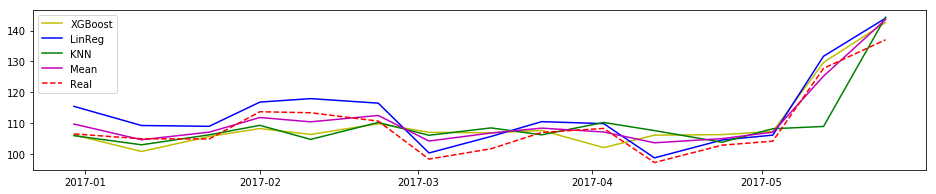

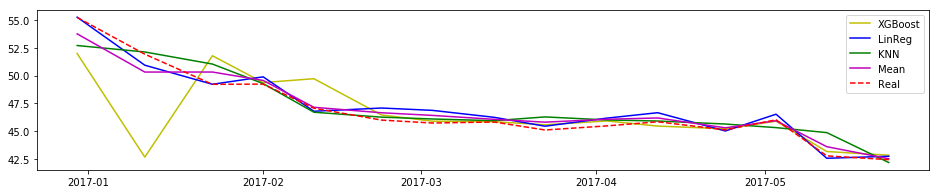

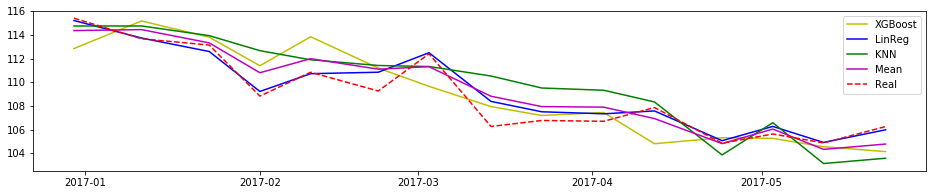

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 0.65069904147837732, 0.049836053291478138, 0.29946490523014446]
        2
0.6507 x + 0.04984 x + 0.2995
Cumulative Return: 1.89586812598; Average Daily Return: 0.00313489810637; Standard Deviation of Daily Returns: 0.0190980302007, Sharpe Ratio: 2.6484925689


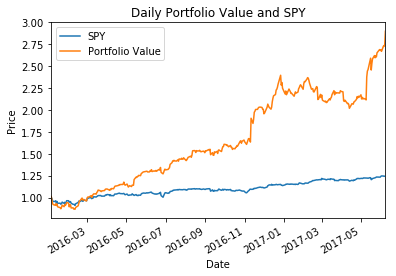

In [245]:
longo(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 7, ['NVDA','HNI','CVX'], True)


Prediction for 1 day(s)
Prediction for NVDA
R2_score KNN 0.887581970645
R2_score Linear Regression 0.997607527476
R2_score XGBoost 0.972016823804
R2_score Mean - Ensemble 0.982377499324
Prediction for HNI
R2_score KNN 0.937320330367
R2_score Linear Regression 0.994933498639
R2_score XGBoost 0.956122133071
R2_score Mean - Ensemble 0.978753145736
Prediction for CVX
R2_score KNN 0.833723148172
R2_score Linear Regression 0.994285341406
R2_score XGBoost 0.977913197325
R2_score Mean - Ensemble 0.976235706632


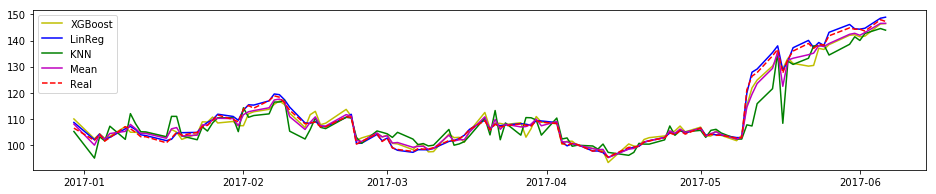

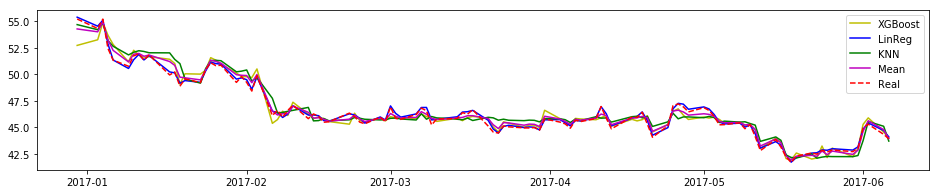

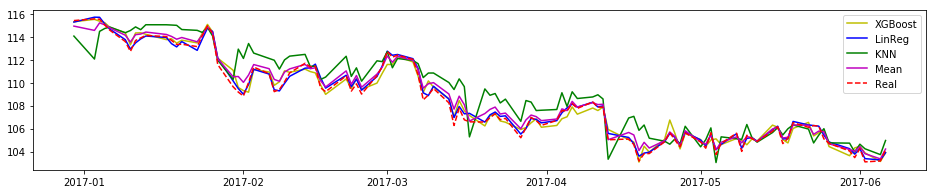

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, array([ 0.65112825]), array([ 0.04980033]), array([ 0.29907142])]
        2
0.6511 x + 0.0498 x + 0.2991
Cumulative Return: 1.89765706816; Average Daily Return: 0.00313679265994; Standard Deviation of Daily Returns: 0.0191077873061, Sharpe Ratio: 2.64851493279


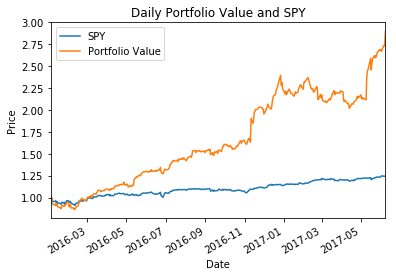

SPY final: 1.24414889577
Portfolio final:  2.89765706816
Gain over SPY:  132.902756094


In [259]:
longo(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 1, ['NVDA','HNI','CVX'], True)

Prediction for 14 day(s)
Prediction for NVDA
R2_score KNN -3.65620650147
R2_score Linear Regression -2.03805706713
R2_score XGBoost -5.69575369925
R2_score Mean - Ensemble -3.37753449655
Prediction for HNI
R2_score KNN -0.683562530763
R2_score Linear Regression 0.891511858065
R2_score XGBoost -1.19151925399
R2_score Mean - Ensemble 0.891511858065
Prediction for CVX
R2_score KNN 0.76199306532
R2_score Linear Regression 0.889037455444
R2_score XGBoost 0.493177684467
R2_score Mean - Ensemble 0.819074738771


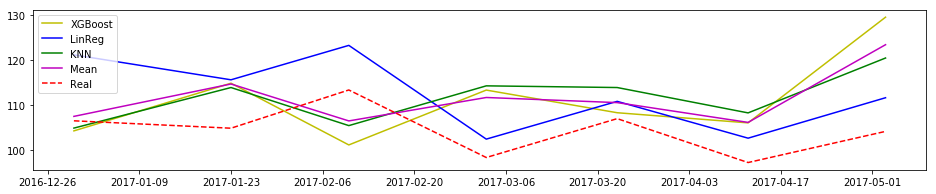

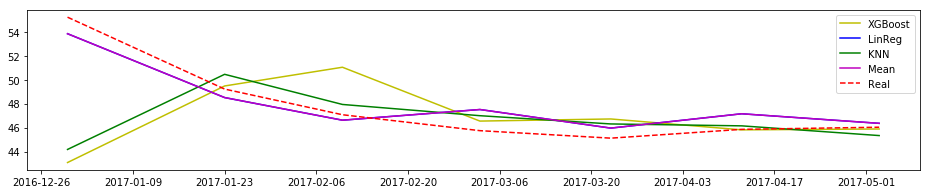

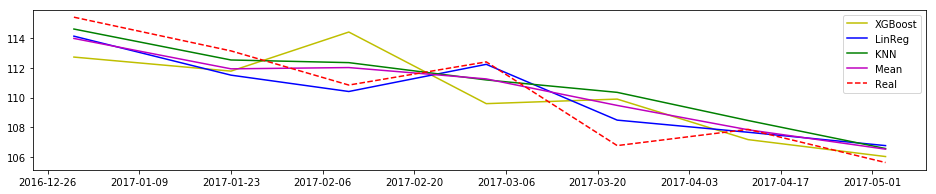

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, array([ 0.65065686]), array([ 0.04987479]), array([ 0.29946836])]
        2
0.6507 x + 0.04987 x + 0.2995
Cumulative Return: 1.89575557585; Average Daily Return: 0.00313477963014; Standard Deviation of Daily Returns: 0.0190974582047, Sharpe Ratio: 2.64848174728


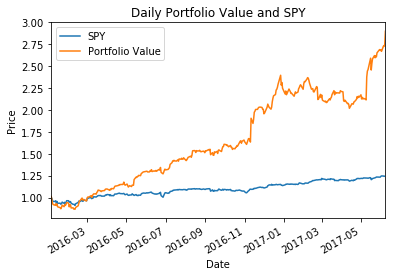

SPY final: 1.24414889577
Portfolio final:  2.89575557585
Gain over SPY:  132.749921307


In [260]:
longo(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 14, ['NVDA','HNI','CVX'], True)

Prediction for 7 day(s)
Prediction for NVDA
R2_score KNN 0.533352868405
R2_score Linear Regression 0.819463637549
R2_score XGBoost 0.778099095279
R2_score Mean - Ensemble 0.900661379854
Prediction for HNI
R2_score KNN 0.891088132722
R2_score Linear Regression 0.962735302107
R2_score XGBoost -0.0144507753938
R2_score Mean - Ensemble 0.963106739464
Prediction for CVX
R2_score KNN 0.588586576082
R2_score Linear Regression 0.945692494842
R2_score XGBoost 0.567109002783
R2_score Mean - Ensemble 0.867197655171


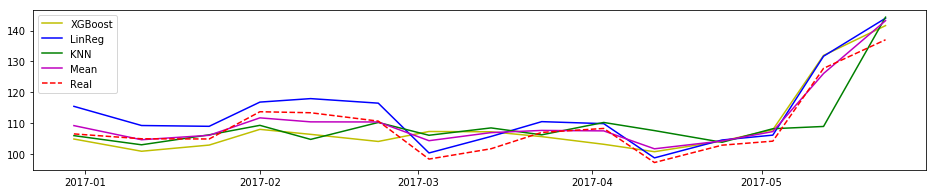

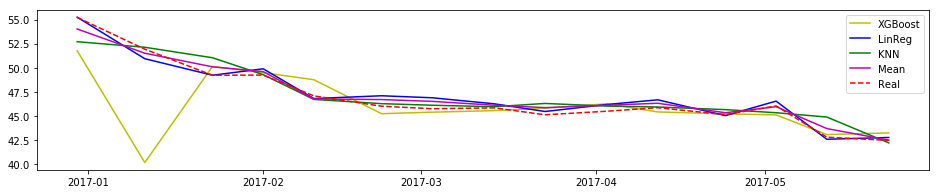

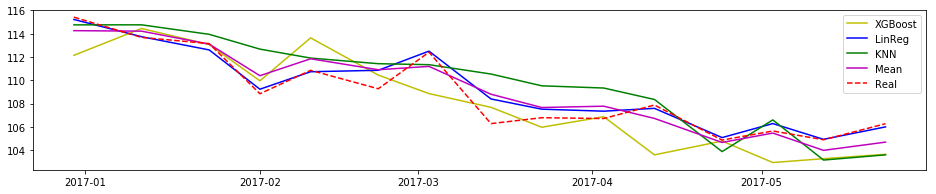

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 0.51214537195195842, 0.018847517485793941, 0.46900711056224753]
        2
0.5121 x + 0.01885 x + 0.469
Cumulative Return: 1.34323657105; Average Daily Return: 0.00249514890001; Standard Deviation of Daily Returns: 0.0160755798936, Sharpe Ratio: 2.63655145416


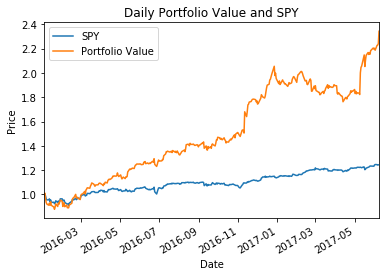

SPY final: 1.24414889577
Portfolio final:  2.34323657105
Gain over SPY:  88.3405257216


In [267]:
longo(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 7, ['NVDA','HNI','CVX'], True)

In [81]:
a,b,c = [],[],[] #(X1,y1) models
d,e,f = [],[],[] #(X2,y2) models
g,h,i = [],[],[] #(X3,y3) models
t = []
r = []
a_err,b_err,c_err = [],[],[]
d_err,e_err,f_err = [],[],[]
g_err,h_err,i_err = [],[],[]
X1 = NVDA_feats
y1 = NVDA_target
ct = 0
n = 0
days = 14
dFrame = y1[0:1]
asd = []

while ct < len(y1[242+days:])-1:
    aa = knn.fit(X1[:242+(n*days)], y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
    a.append(aa.tolist())
    bb = regr.fit(X1[:242+(n*days)],  y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
    b.append(bb.tolist())
    cc = xb.fit(X1[:242+(n*days)],  y1[days:242+days+(n*days)]).predict(X1[242+(n*days):243+(n*days)])
    c.append(cc.tolist())

    asd.append(a[n]+b[n]+c[n])

    t.append(y1.values[242+(n*days):243+(n*days)].tolist())
    dFrame = dFrame.append(y1[242+(n*days):243+(n*days)])   
    n += 1
    ct += days

# Alternative function
* curto() is based on longo() function, the difference is that it tests only on the specified date and doesn't roll over the data through the end of the period.

In [471]:
def curto(X1, y1, X2, y2, X3, y3, days, symbols, debug):
    a,b,c = [],[],[] #(X1,y1) models NVDA
    d,e,f = [],[],[] #(X2,y2) models HNI
    g,h,i = [],[],[] #(X3,y3) models CVX
    t,tt,ttt = [],[],[]
    r,rr,rrr = [],[],[]
    a_err,b_err,c_err = [],[],[]
    d_err,e_err,f_err = [],[],[]
    g_err,h_err,i_err = [],[],[]
    ct = 0
    n = 0
    dFrame1 = y1[0:1]
    dFrame2 = y2[0:1]
    dFrame3 = y3[0:1]
    best1,best2,best3 = [],[],[]
    list_best = []
    #pct_original = [0.5114, 0.0189, 0.4697]
    pct_original = [ 0.65, 0.05, 0.3]
    
    
    aa = knn_nvda.fit(X1[:242], y1[days:242+days]).predict(X1[242+days:243+days])
    print 'aa: ', aa
    print y1[242+days]
    a.append(aa.tolist())
    bb = regr.fit(X1[:242], y1[days:242+days]).predict(X1[242+days:243+days])
    print 'bb: ', bb
    b.append(bb.tolist())
    cc = xb_alt.fit(X1[:242], y1[days:242+days]).predict(X1[242+days:243+days])
    c.append(cc.tolist())
    zz = np.mean([aa,bb,cc])
    print zz

    dd = knn_hni.fit(X2[:242], y2[days:242+days]).predict(X2[242+days:243+days])
    d.append(dd.tolist())
    ee = regr.fit(X2[:242], y2[days:242+days]).predict(X2[242+days:243+days])
    e.append(ee.tolist())
    ff = xb_alt.fit(X2[:242], y2[days:242+days]).predict(X2[242+days:243+days])
    f.append(ff.tolist())

    gg = knn_cvx.fit(X3[:242], y3[days:242+days]).predict(X3[242+days:243+days])
    g.append(gg.tolist())
    hh = regr.fit(X3[:242], y3[days:242+days]).predict(X3[242+days:243+days])
    h.append(hh.tolist())
    ii = xb_alt.fit(X3[:242], y3[days:242+days]).predict(X3[242+days:243+days])
    i.append(ii.tolist())

    t.append(y1.values[242+days:243+days].tolist())
    tt.append(y2.values[242+days:243+days].tolist())
    ttt.append(y3.values[242+days:243+days].tolist())
    dFrame1 = dFrame1.append(y1[242+days:243+days])   
    dFrame2 = dFrame2.append(y2[242+days:243+days])  
    dFrame3 = dFrame3.append(y3[242+days:243+days])  
    n += 1
    ct += days

    dFrame1 = dFrame1.drop(dFrame1.index[0])
    dFrame2 = dFrame2.drop(dFrame2.index[0])
    dFrame3 = dFrame3.drop(dFrame3.index[0])
    
    # Scores (X1,y1)
    j = mean_squared_error(t, a)
    k = mean_squared_error(t, b)
    l = mean_squared_error(t, c) 
    
    
    # Scores (X2,y2)
    jj = mean_squared_error(tt, d)
    kk = mean_squared_error(tt, e)
    ll = mean_squared_error(tt, f) 

    
    
    # Scores (X3,y3)
    jjj = mean_squared_error(ttt, g)
    kkk = mean_squared_error(ttt, h)
    lll = mean_squared_error(ttt, i) 

    
    if debug:
        print 'Prediction for ' + str(days) + ' day(s)'
        print 'Prediction for ' + symbols[0]
        print 'mean_squared_error KNN', j
        print 'mean_squared_error Linear Regression', k
        print 'mean_squared_error XGBoost', l 
        print 'Prediction for ' + symbols[1]
        print 'mean_squared_error KNN', jj
        print 'mean_squared_error Linear Regression', kk
        print 'mean_squared_error XGBoost', ll 
        print 'Prediction for ' + symbols[2]
        print 'mean_squared_error KNN', jjj
        print 'mean_squared_error Linear Regression', kkk
        print 'mean_squared_error XGBoost', lll 
        
        
    best1 = best_score2(j,k,l, a,b,c)
    best2 = best_score2(jj,kk,ll, d,e,f)
    best3 = best_score2(jjj,kkk,lll, g,h,i)
    
    
    list_best.append([best1, best2, best3])
        

    old_price = [y1[243-days], y2[243-days], y3[243-days]]
    print 'Predicted values: ',best1, best2, best3
    print 'Real values: ',old_price
    pcs = calc_pct(list_best, old_price) 
    
    order(pcs, dFrame1)
        
    Cguess = distribution(pct_original, pcs)
    Cguess.insert(0,0.0)
    #print Cguess
    
    #dates = pd.date_range('2016-01-01', '2017-06-08')
    #df = get_data(symbols, dates)
    #poly(df, symbols, Cguess)

In [382]:
curto(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 5, ['NVDA','HNI','CVX'], True)

aa:  [ 109.411541]
107.032051
bb:  [ 110.38774859]
108.107578238
Prediction for 5 day(s)
Prediction for NVDA
mean_squared_error KNN 5.6619726601
mean_squared_error Linear Regression 11.2607062835
mean_squared_error XGBoost 6.29310341404
Prediction for HNI
mean_squared_error KNN 5.36406984613
mean_squared_error Linear Regression 1.50328856166
mean_squared_error XGBoost 87.9568071335
Prediction for CVX
mean_squared_error KNN 2.90206306849
mean_squared_error Linear Regression 0.112214367928
mean_squared_error XGBoost 1.00736887196
Predicted values:  [[109.411541]] [[49.53506031396814]] [[113.92123413085938]]
Real values:  [109.526276, 54.889191000000004, 116.11605800000001]


In [308]:
from sklearn.metrics import mean_squared_error

In [303]:
def best_score2(s1,s2,s3, l1,l2,l3):
    ss = [s1,s2,s3]
    if ss.index(min(ss)) == 0:
        return l1
    elif ss.index(min(ss)) == 1:
        return l2
    else:
        return l3


# Order function:
* suggests if the user should buy or sell depending on the movements of the stock

In [18]:
def order(pcs):

    if float(pcs[0]) < 0.0:
        er = 'sell'
        if float(pcs[1]) < 0.0:
            rt = 'sell'
            if float(pcs[2]) < 0.0:
                ty = 'sell'
            else:
                ty = 'buy'
        else:
            rt = 'buy'
            if float(pcs[2]) < 0.0:
                ty = 'sell'
            else:
                ty = 'buy'
    else:
        er = 'buy'
        if float(pcs[1]) < 0.0:
            rt = 'sell'
            if float(pcs[2]) < 0.0:
                ty = 'sell'
            else:
                ty = 'buy'
        else:
            rt = 'buy'
            if float(pcs[2]) < 0.0:
                ty = 'sell'
            else:
                ty = 'buy' 
    
    return [er,rt,ty]
'''''
asd = str(data.index)
ordem = open('order.txt', 'w')
ordem.write(asd[16:26])
ordem.write(" : ")
ordem.write(str(qwe))
ordem.close()
'''''

'\'\'\nasd = str(data.index)\nordem = open(\'order.txt\', \'w\')\nordem.write(asd[16:26])\nordem.write(" : ")\nordem.write(str(qwe))\nordem.close()\n'

Prediction for 7 day(s)
Prediction for NVDA
R2_score KNN 0.533352868405
R2_score Linear Regression 0.819463637549
R2_score XGBoost 0.778099095279
R2_score Mean - Ensemble 0.900661379854
Prediction for HNI
R2_score KNN 0.891088132722
R2_score Linear Regression 0.962735302107
R2_score XGBoost -0.0144507753938
R2_score Mean - Ensemble 0.963106739464
Prediction for CVX
R2_score KNN 0.588586576082
R2_score Linear Regression 0.945692494842
R2_score XGBoost 0.567109002783
R2_score Mean - Ensemble 0.867197655171


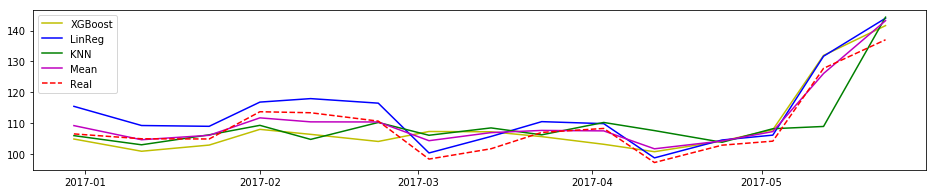

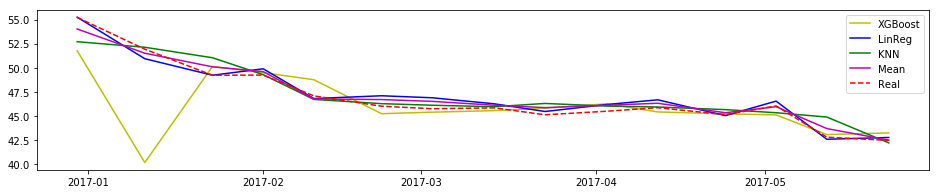

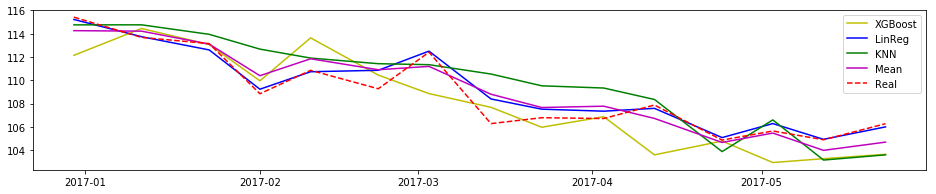

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 0.65070923127667368, 0.049842915449107954, 0.29944785327421841]
        2
0.6507 x + 0.04984 x + 0.2994
Cumulative Return: 1.8959244161; Average Daily Return: 0.00313495789933; Standard Deviation of Daily Returns: 0.0190983463994, Sharpe Ratio: 2.64849121697


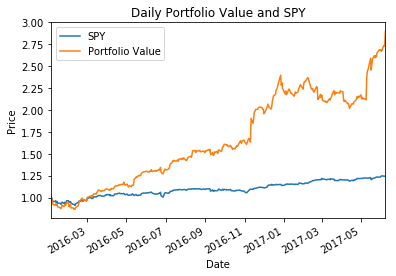

SPY final: 1.24414889577
Portfolio final:  2.8959244161
Gain over SPY:  132.76349205


In [416]:
longo(NVDA_feats, NVDA_target,HNI_feats, HNI_target, CVX_feats, CVX_target, 7, ['NVDA','HNI','CVX'], True)

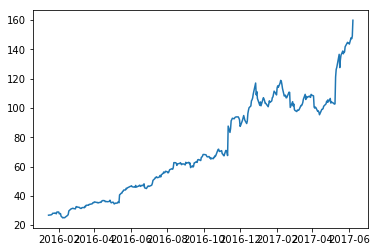

In [411]:
plt.plot(NVDA_target)
plt.savefig('testplot.jpg')

# Results with PCA data

In [418]:
from sklearn.decomposition import PCA
pca_NVDA = PCA(n_components=2).fit(NVDA_feats)
reduced_data_NVDA = pca_NVDA.transform(NVDA_feats)
reduced_data_NVDA = pd.DataFrame(reduced_data_NVDA, columns = ['Dimension 1', 'Dimension 2'])

pca_HNI = PCA(n_components=2).fit(HNI_feats)
reduced_data_HNI = pca_HNI.transform(HNI_feats)
reduced_data_HNI = pd.DataFrame(reduced_data_HNI, columns = ['Dimension 1', 'Dimension 2'])

pca_CVX = PCA(n_components=2).fit(CVX_feats)
reduced_data_CVX = pca_CVX.transform(CVX_feats)
reduced_data_CVX = pd.DataFrame(reduced_data_CVX, columns = ['Dimension 1', 'Dimension 2'])

Prediction for 1 day(s)
Prediction for NVDA
R2_score KNN 0.922501932308
R2_score Linear Regression 0.987814438877
R2_score XGBoost 0.934979585761
R2_score Mean - Ensemble 0.967116240669
Prediction for HNI
R2_score KNN 0.935841560731
R2_score Linear Regression 0.987470931512
R2_score XGBoost 0.941819846435
R2_score Mean - Ensemble 0.966853813235
Prediction for CVX
R2_score KNN 0.948504828877
R2_score Linear Regression 0.983586549346
R2_score XGBoost 0.949956419374
R2_score Mean - Ensemble 0.978278378181


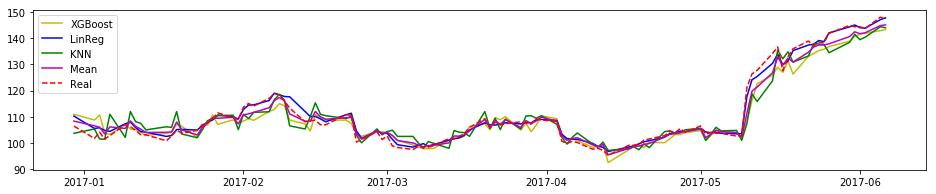

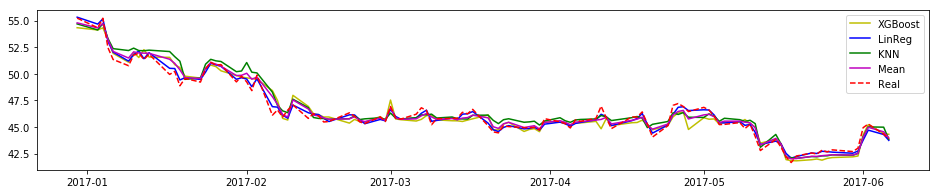

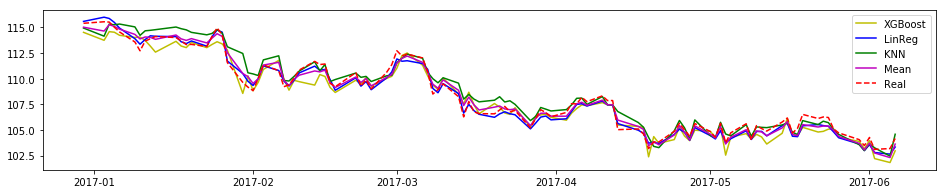

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.10822183174727, 4.980421263308036, 29.911356904944686]
       2
65.11 x + 4.98 x + 29.91
Cumulative Return: 1.89746524583; Average Daily Return: 0.00313658956198; Standard Deviation of Daily Returns: 0.0191067411902, Sharpe Ratio: 2.64851253146


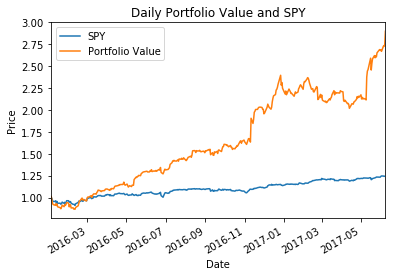

SPY final: 1.24414889577
Portfolio final:  2.89746524583
Gain over SPY:  132.887338138


In [457]:
longo(reduced_data_NVDA, NVDA_target,reduced_data_HNI, HNI_target, reduced_data_CVX, CVX_target, 1, ['NVDA','HNI','CVX'], True)

# Results with reduced-features data

In [422]:
red_feats_normed_NVDA = NVDA_feats.drop(['Open','Close','High','Low'], axis=1)
red_feats_normed_HNI = HNI_feats.drop(['Open','Close','High','Low'], axis=1)
red_feats_normed_CVX = CVX_feats.drop(['Open','Close','High','Low'], axis=1)

Prediction for 1 day(s)
Prediction for NVDA
R2_score KNN 0.865690084479
R2_score Linear Regression 0.998296313427
R2_score XGBoost 0.943880511969
R2_score Mean - Ensemble 0.973730483172
Prediction for HNI
R2_score KNN 0.913543680575
R2_score Linear Regression 0.99579153951
R2_score XGBoost 0.941451602192
R2_score Mean - Ensemble 0.978645171821
Prediction for CVX
R2_score KNN 0.825266463243
R2_score Linear Regression 0.994706546953
R2_score XGBoost 0.953141814719
R2_score Mean - Ensemble 0.981550376095


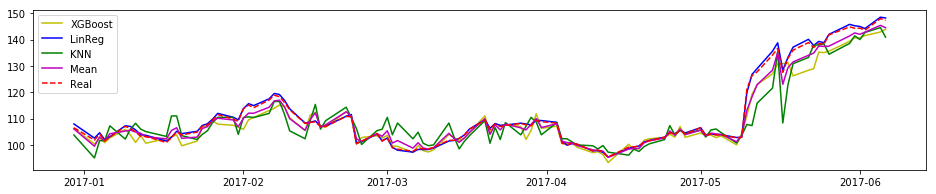

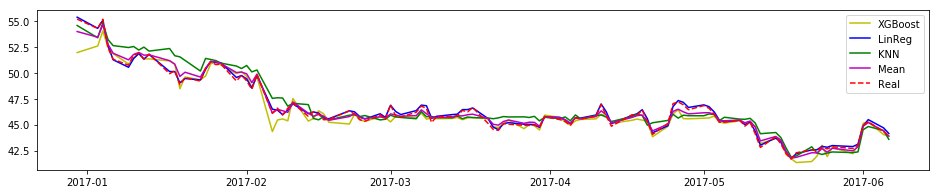

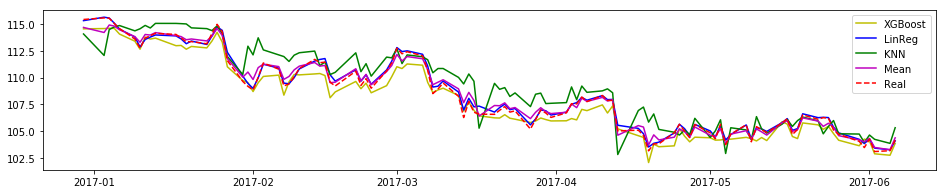

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.11265007182018, 4.980080576021558, 29.907269352158266]
       2
65.11 x + 4.98 x + 29.91
Cumulative Return: 1.89765038829; Average Daily Return: 0.00313678559464; Standard Deviation of Daily Returns: 0.019107751269, Sharpe Ratio: 2.64851476146


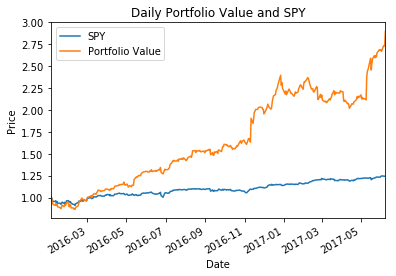

SPY final: 1.24414889577
Portfolio final:  2.89765038829
Gain over SPY:  132.902219192


In [456]:
longo(red_feats_normed_NVDA, NVDA_target,red_feats_normed_HNI, HNI_target, red_feats_normed_CVX, CVX_target, 1, ['NVDA','HNI','CVX'], True)

Prediction for 7 day(s)
Prediction for NVDA
R2_score KNN 0.593230989679
R2_score Linear Regression 0.856920973066
R2_score XGBoost 0.699334706043
R2_score Mean - Ensemble 0.905057981454
Prediction for HNI
R2_score KNN 0.870504614828
R2_score Linear Regression 0.966272475327
R2_score XGBoost -0.0374760815263
R2_score Mean - Ensemble 0.956793459795
Prediction for CVX
R2_score KNN 0.588586576082
R2_score Linear Regression 0.949426011353
R2_score XGBoost 0.587795084265
R2_score Mean - Ensemble 0.859143577649


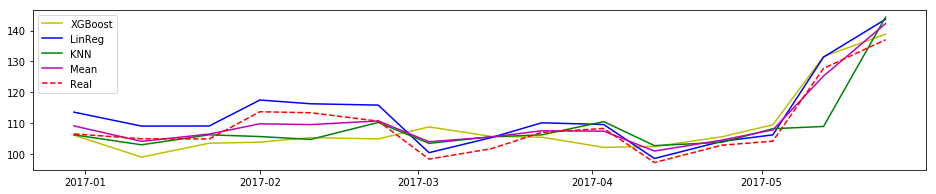

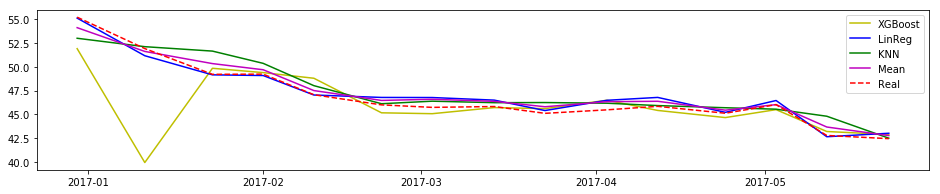

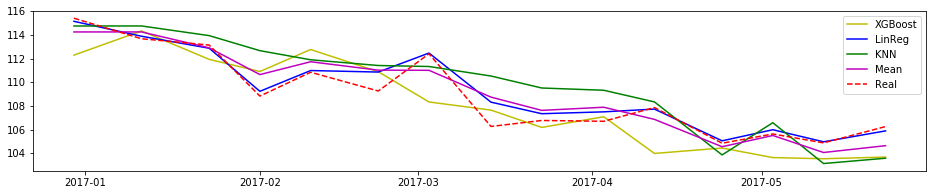

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.06963511140953, 4.983621318459571, 29.946743570130902]
       2
65.07 x + 4.984 x + 29.95
Cumulative Return: 1.89585680233; Average Daily Return: 0.00313488610969; Standard Deviation of Daily Returns: 0.0190979683611, Sharpe Ratio: 2.64849244374


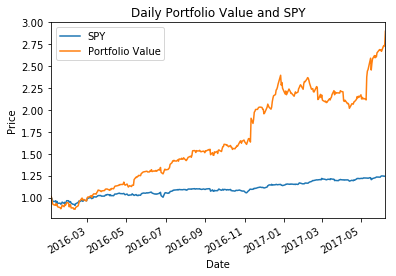

SPY final: 1.24414889577
Portfolio final:  2.89585680233
Gain over SPY:  132.758057511


In [460]:
longo(red_feats_normed_NVDA, NVDA_target,red_feats_normed_HNI, HNI_target, red_feats_normed_CVX, CVX_target, 7, ['NVDA','HNI','CVX'], True)

Prediction for 14 day(s)
Prediction for NVDA
R2_score KNN -2.61477241224
R2_score Linear Regression -1.3304898547
R2_score XGBoost -2.53539704941
R2_score Mean - Ensemble -1.69049654476
Prediction for HNI
R2_score KNN -0.767435406648
R2_score Linear Regression 0.889061530597
R2_score XGBoost -3.01104556235
R2_score Mean - Ensemble 0.889061530597
Prediction for CVX
R2_score KNN 0.76199306532
R2_score Linear Regression 0.914104037451
R2_score XGBoost 0.520474960196
R2_score Mean - Ensemble 0.847970308279


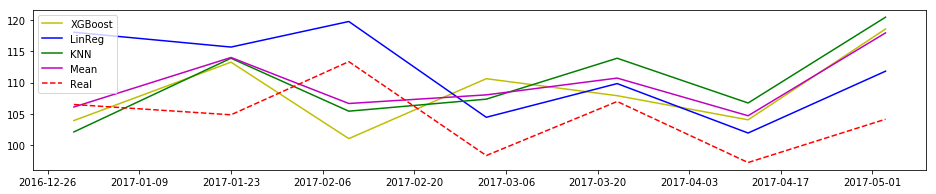

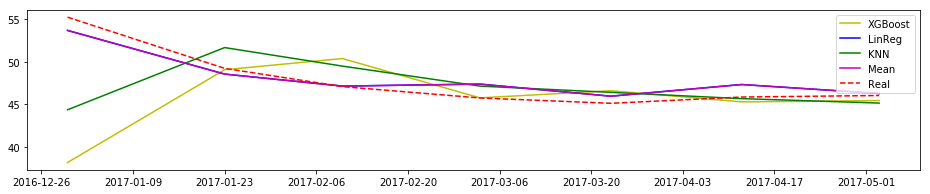

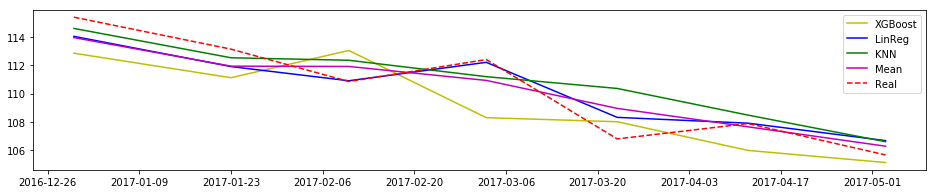

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.05904443878256, 4.988460885283798, 29.95249467593363]
       2
65.06 x + 4.988 x + 29.95
Cumulative Return: 1.89548661769; Average Daily Return: 0.00313449478979; Standard Deviation of Daily Returns: 0.0190959962852, Sharpe Ratio: 2.64847721499


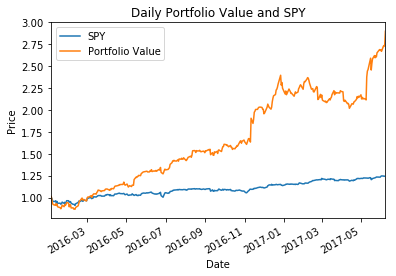

SPY final: 1.24414889577
Portfolio final:  2.89548661769
Gain over SPY:  132.728303464


In [458]:
longo(red_feats_normed_NVDA, NVDA_target,red_feats_normed_HNI, HNI_target, red_feats_normed_CVX, CVX_target, 14, ['NVDA','HNI','CVX'], True)

Prediction for 28 day(s)
Prediction for NVDA
R2_score KNN -1.06941315872
R2_score Linear Regression -16.0643922881
R2_score XGBoost -1.95031403985
R2_score Mean - Ensemble -12.2561656816
Prediction for HNI
R2_score KNN -2.54283544175
R2_score Linear Regression 0.392816761778
R2_score XGBoost -5.31177868646
R2_score Mean - Ensemble 0.392816761778
Prediction for CVX
R2_score KNN 0.446723944742
R2_score Linear Regression 0.587092773762
R2_score XGBoost -0.687462302707
R2_score Mean - Ensemble 0.531832987555


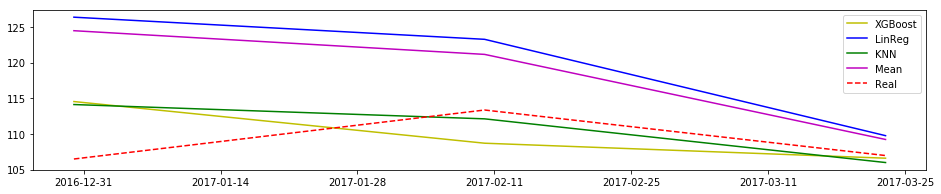

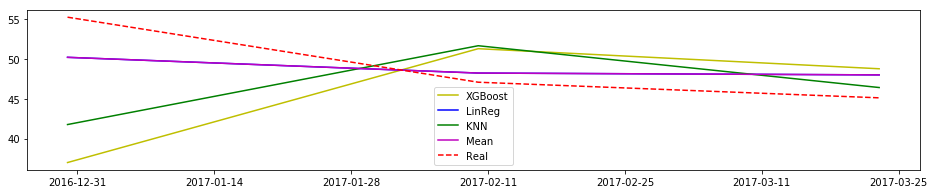

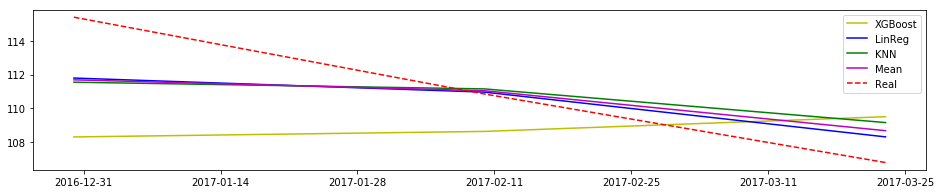

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.04510933991011, 4.990146731378752, 29.964743928711137]
       2
65.05 x + 4.99 x + 29.96
Cumulative Return: 1.89491564802; Average Daily Return: 0.00313388994678; Standard Deviation of Daily Returns: 0.0190928881201, Sharpe Ratio: 2.64846860706


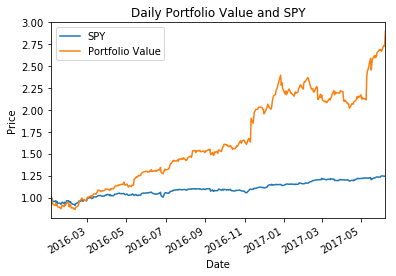

SPY final: 1.24414889577
Portfolio final:  2.89491564802
Gain over SPY:  132.682411074


In [459]:
longo(red_feats_normed_NVDA, NVDA_target,red_feats_normed_HNI, HNI_target, red_feats_normed_CVX, CVX_target, 28, ['NVDA','HNI','CVX'], True)

# Test with noisy data:
* The HNI csv file was manually modified, creating peaks only in the target (Adjusted Close)

In [5]:
eps_finder('HNI')

[u'1.08', u'1.41', u'1.37', u'2.38', u'1.93']

In [6]:
def prepare_data2(symbol):
    df = pd.read_csv("data/" +symbol.upper() + ".csv", index_col="Date",usecols=["Date","Open","High", "Low","Close", "Volume", "Adj Close"], parse_dates=True, na_values=['nan'])
    feats = df.drop('Adj Close', 1)
    target = df['Adj Close']
    feats.loc[:,'Daily_var'] = feats.loc[:,'High'] - feats.loc[:,'Low']
    feats.loc[:,'Pct_var'] = feats.loc[:,'Daily_var'] / feats.loc[:,'Open'] * 100
    # compute Daily Returns
    daily_returns = (target / target.shift(1)) - 1
    daily_returns.iloc[0] = 0
    #print daily_returns
    feats.loc[:,'Daily_rets'] = daily_returns
    # Compute Cumulative Returns
    cum_ret = (target / target.iloc[0]) - 1
    cum_ret.iloc[0] = 0
    feats.loc[:,'Cum_rets'] = cum_ret
    # Computing rolling statistics
    rm_NVDA = pd.rolling_mean(target, window=10)
    feats.loc[:,'SMA'] = rm_NVDA
    # Computing PE ratio
    pe_ratio = feats.Close / 1.93
    feats.loc[:,'PE_ratio'] = pe_ratio
    # Eliminando os primeiros dias por causa do SMA - valores NaN 
    feats = feats.loc['2016-01-15':]
    target = target.loc['2016-01-15':]
    # Normalize data
    scaler = MinMaxScaler(feature_range=(-1,1), copy=True)
    feats_normed = scaler.fit_transform(feats)
    p = feats_normed
    # convert numpy.array -> pandas.DataFrame
    feats_normed = pd.DataFrame({'Open':p[:,0],'High':p[:,1],'Low':p[:,2],'Close':p[:,3],
                                 'Volume':p[:,4], 'Daily_var':p[:,5], 'Pct_var':p[:,6],'SMA':p[:,7], 
                                 'PE_ratio':p[:,8], 'Daily_rets':p[:,9], 'Cum_rets':p[:,10]})
    # Recolocar indice de datas no dataframe normalizado
    feats_normed['Date'] = feats.index
    feats_normed = feats_normed.set_index('Date')
    return feats_normed, target

In [8]:
HNI_noisy_feats, HNI_noisy_target = prepare_data2('HNI_noisy')

/Users/mauricioaroldi/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


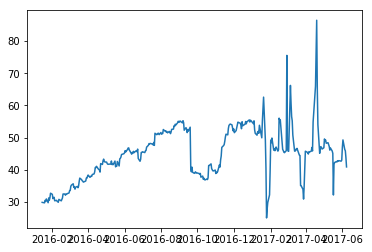

In [21]:
plt.plot(HNI_noisy_target)

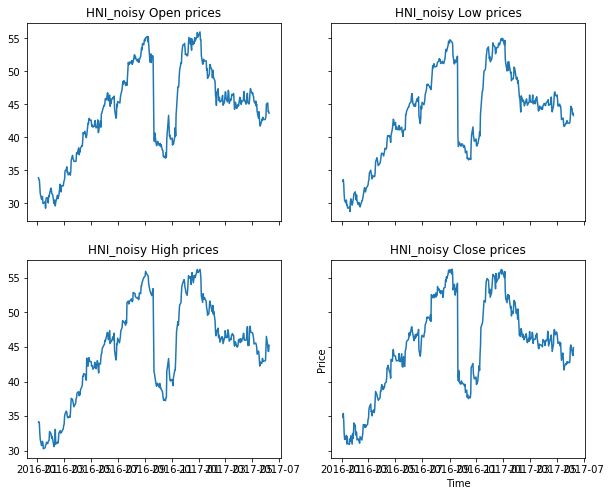

In [24]:
dff = pd.read_csv("data/HNI_noisy.csv", index_col="Date",usecols=["Date","Open","High", "Low","Close", "Volume", "Adj Close"], parse_dates=True, na_values=['nan'])
fea = dff.drop('Adj Close', 1)
tar = dff['Adj Close']
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col', sharey='row',figsize=(10,8))
ax1.set_title('HNI_noisy Open prices')
plt.ylabel('Price')
plt.xlabel('Time')
ax1.plot(fea.index, fea.Open)
ax2.set_title('HNI_noisy Low prices')
ax2.plot(fea.index, fea.Low)
ax3.set_title('HNI_noisy High prices')
ax3.plot(fea.index, fea.High)
ax4.set_title('HNI_noisy Close prices')
ax4.plot(fea.index, fea.Close,)

Prediction for 1 day(s)
Prediction for NVDA
R2_score KNN 0.887581970645
R2_score Linear Regression 0.997607527476
R2_score XGBoost 0.947874206242
R2_score Mean - Ensemble 0.977798991111
Prediction for HNI
R2_score KNN 0.403826030202
R2_score Linear Regression 0.887481971798
R2_score XGBoost 0.637299591883
R2_score Mean - Ensemble 0.830447002476
Prediction for CVX
R2_score KNN 0.833723148172
R2_score Linear Regression 0.994285341406
R2_score XGBoost 0.950235353187
R2_score Mean - Ensemble 0.98309419394


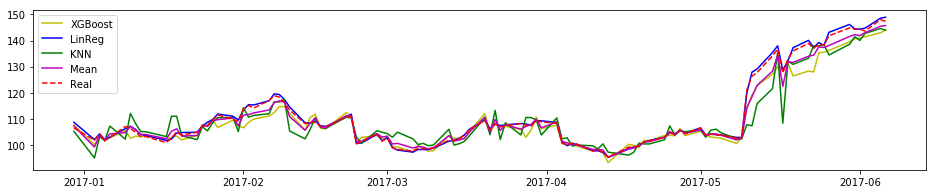

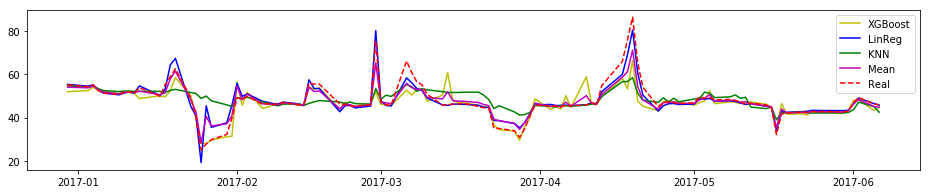

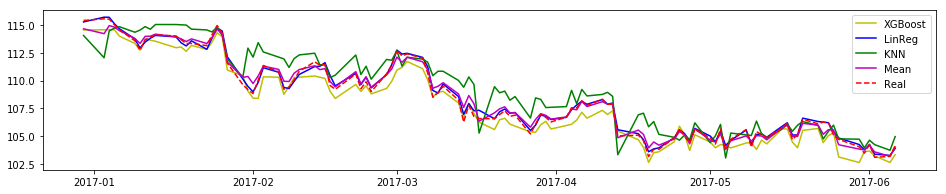

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.06252769806845, 5.05343177333449, 29.884040528597065]
       2
65.06 x + 5.053 x + 29.88
Cumulative Return: 1.89680339465; Average Daily Return: 0.00313590356571; Standard Deviation of Daily Returns: 0.0191039587818, Sharpe Ratio: 2.64831912435


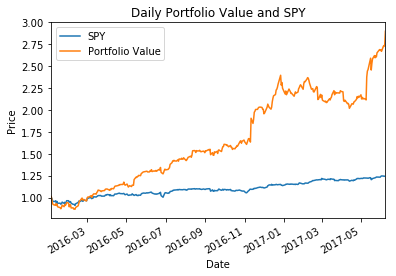

SPY final: 1.24414889577
Portfolio final:  2.89680339465
Gain over SPY:  132.834141035


In [20]:
longo(NVDA_feats, NVDA_target,HNI_noisy_feats, HNI_noisy_target, CVX_feats, CVX_target, 1, ['NVDA','HNI','CVX'], True)

Prediction for 7 day(s)
Prediction for NVDA
R2_score KNN 0.533352868405
R2_score Linear Regression 0.819463637549
R2_score XGBoost 0.778099095279
R2_score Mean - Ensemble 0.900661379854
Prediction for HNI
R2_score KNN 0.236266982141
R2_score Linear Regression 0.297992336142
R2_score XGBoost -2.22199187766
R2_score Mean - Ensemble 0.41237935057
Prediction for CVX
R2_score KNN 0.588586576082
R2_score Linear Regression 0.945692494842
R2_score XGBoost 0.567109002783
R2_score Mean - Ensemble 0.867197655171


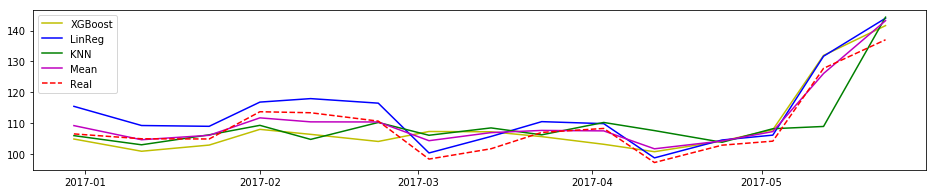

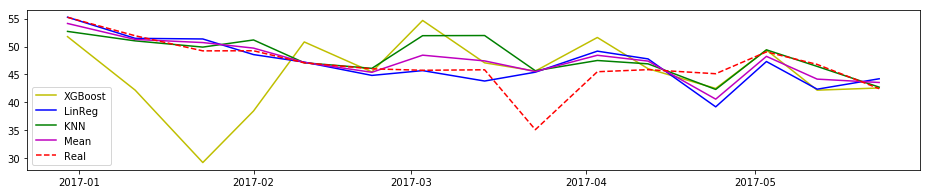

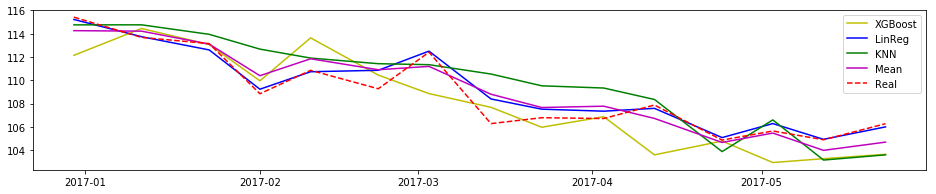

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.06942288210097, 4.986482183809021, 29.94409493409]
       2
65.07 x + 4.986 x + 29.94
Cumulative Return: 1.89589898073; Average Daily Return: 0.00313493139657; Standard Deviation of Daily Returns: 0.0190982322417, Sharpe Ratio: 2.64848538041


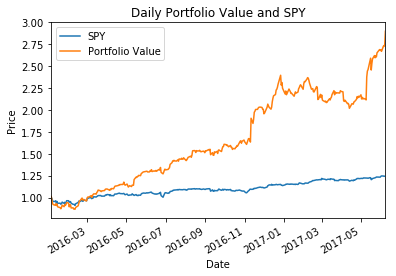

SPY final: 1.24414889577
Portfolio final:  2.89589898073
Gain over SPY:  132.761447652


In [25]:
longo(NVDA_feats, NVDA_target,HNI_noisy_feats, HNI_noisy_target, CVX_feats, CVX_target, 7, ['NVDA','HNI','CVX'], True)

Prediction for 14 day(s)
Prediction for NVDA
R2_score KNN -3.65620650147
R2_score Linear Regression -2.03805706713
R2_score XGBoost -2.11851760827
R2_score Mean - Ensemble -1.78177944464
Prediction for HNI
R2_score KNN -0.121841823813
R2_score Linear Regression 0.328762202396
R2_score XGBoost -1.56277428683
R2_score Mean - Ensemble 0.328762202396
Prediction for CVX
R2_score KNN 0.76199306532
R2_score Linear Regression 0.889037455444
R2_score XGBoost 0.537381605206
R2_score Mean - Ensemble 0.832669297799


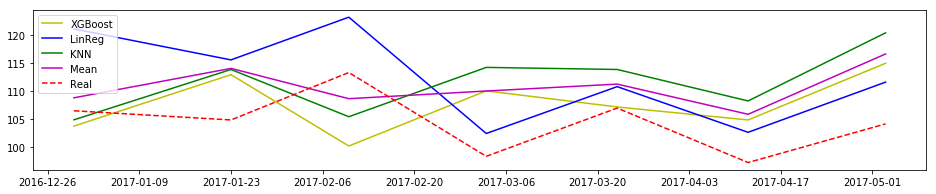

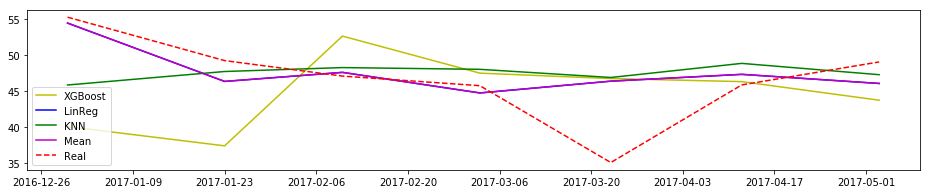

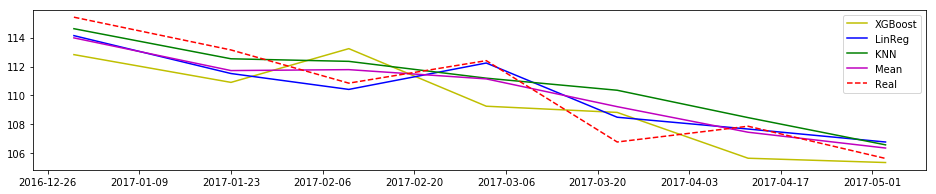

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.06045314756004, 4.988718688049555, 29.950828164390398]
       2
65.06 x + 4.989 x + 29.95
Cumulative Return: 1.89555202833; Average Daily Return: 0.0031345641674; Standard Deviation of Daily Returns: 0.0190963575308, Sharpe Ratio: 2.64847703666


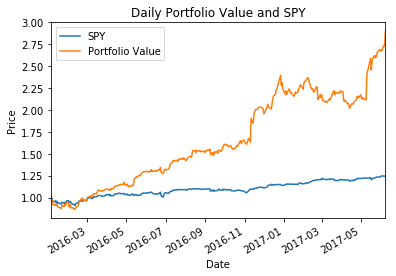

SPY final: 1.24414889577
Portfolio final:  2.89555202833
Gain over SPY:  132.733560925


In [26]:
longo(NVDA_feats, NVDA_target,HNI_noisy_feats, HNI_noisy_target, CVX_feats, CVX_target, 14, ['NVDA','HNI','CVX'], True)

Prediction for 28 day(s)
Prediction for NVDA
R2_score KNN -1.16656078477
R2_score Linear Regression -25.7610977029
R2_score XGBoost -2.31080933196
R2_score Mean - Ensemble -20.6258467724
Prediction for HNI
R2_score KNN -0.965780364021
R2_score Linear Regression -0.180524517303
R2_score XGBoost -2.39886667965
R2_score Mean - Ensemble -1.81438767935
Prediction for CVX
R2_score KNN 0.446723944742
R2_score Linear Regression 0.425785052819
R2_score XGBoost -0.0838973935676
R2_score Mean - Ensemble 0.448391097726


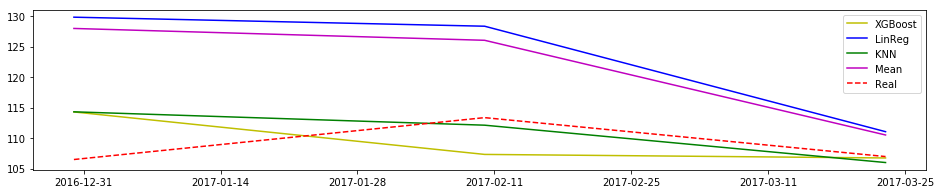

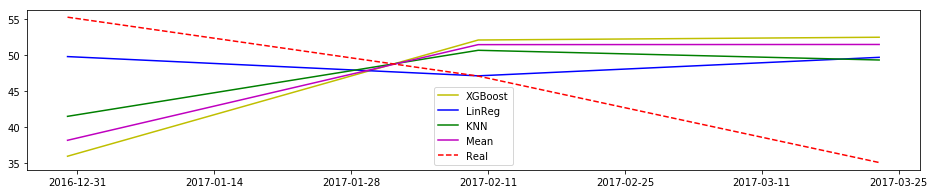

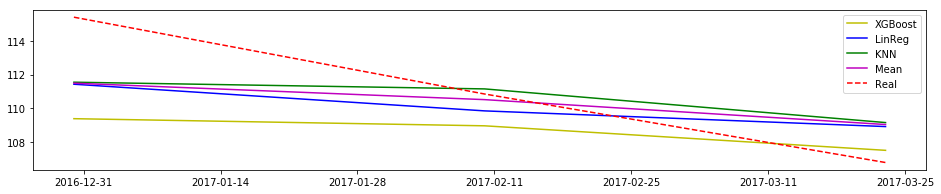

Allocations for ['SPY', 'NVDA', 'HNI', 'CVX']: [0.0, 65.04673286548997, 4.989126286566763, 29.96414084794327]
       2
65.05 x + 4.989 x + 29.96
Cumulative Return: 1.89496738539; Average Daily Return: 0.00313394457906; Standard Deviation of Daily Returns: 0.0190931598053, Sharpe Ratio: 2.64847162653


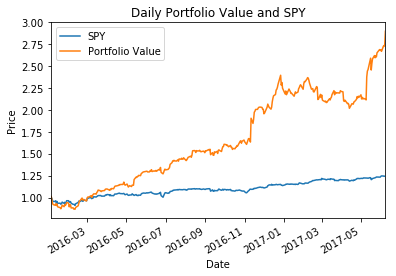

SPY final: 1.24414889577
Portfolio final:  2.89496738539
Gain over SPY:  132.686569529


In [29]:
longo(NVDA_feats, NVDA_target,HNI_noisy_feats, HNI_noisy_target, CVX_feats, CVX_target, 28, ['NVDA','HNI','CVX'], True)